# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 207983669, 318449188 ***

In [2]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [4]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

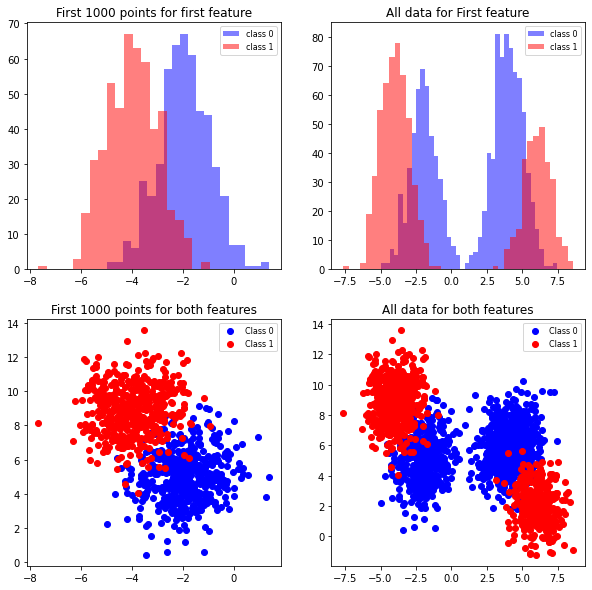

In [5]:
feature1_class0_1000_ = []
feature1_class1_1000 = []
both_features_class0_1000 = []
both_features_class1_1000 = []
all_feature1_class_0 = []
all_feature1_class_1 = []
all_both_class_0 = []
all_both_class_1 = []

for i in range(X_training.shape[0]):
    if i < 1000:
        if y_training[i] == 0:
            feature1_class0_1000_.append(X_training[i][0])
            both_features_class0_1000.append(X_training[i][1])
        else:
            feature1_class1_1000.append(X_training[i][0])
            both_features_class1_1000.append(X_training[i][1])
    
    if y_training[i] == 0:
        all_feature1_class_0.append(X_training[i][0])
        all_both_class_0.append(X_training[i][1])
    else:
        all_feature1_class_1.append(X_training[i][0])
        all_both_class_1.append(X_training[i][1])

# visualizing data
figure, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].hist(feature1_class0_1000_, bins=20, facecolor='b', alpha=0.5, label="class 0")
axes[0, 0].hist(feature1_class1_1000, bins=20, facecolor='r', alpha=0.5, label="class 1")
axes[0, 0].title.set_text("First 1000 points for first feature")
axes[0, 0].legend(prop={'size': 8})

axes[0, 1].hist(all_feature1_class_0, bins=40, facecolor='b', alpha=0.5, label='class 0')
axes[0, 1].hist(all_feature1_class_1, bins=40, facecolor='r', alpha=0.5, label='class 1')
axes[0, 1].title.set_text("All data for First feature")
axes[0, 1].legend(prop={'size': 8})

axes[1, 0].scatter(feature1_class0_1000_, both_features_class0_1000, color='b', label='Class 0')
axes[1, 0].scatter(feature1_class1_1000, both_features_class1_1000, color='r', label='Class 1')
axes[1, 0].title.set_text("First 1000 points for both features")
axes[1, 0].legend(prop={'size': 8})

axes[1, 1].scatter(all_feature1_class_0, all_both_class_0, color='b', label='Class 0')
axes[1, 1].scatter(all_feature1_class_1, all_both_class_1, color='r', label='Class 1')
axes[1, 1].title.set_text("All data for both features")
axes[1, 1].legend(prop={'size': 8})

plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.costs = []
        self.theta = []
        
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """        
        n_instances = X.shape[0]
        n_features = X.shape[1]
        
        #initialize the theta vector
        self.init_theta(n_features)

        # bias trick
        X = np.c_[np.ones(n_instances), X]
        
        # calculate intial cost
        cur_cost = self.calc_cost(X, y)
        self.costs.append(cur_cost)
        
        for epoc in range(self.n_iter):
            
            # hold current theta
            theta = self.theta
            
            # calc current hypothesis
            cur_h = self.sigmoid(X)
            theta -= (self.eta / n_instances) * np.dot(X.T, (cur_h - y))
            
            # calculate costs
            prev_cost = cur_cost
            cur_cost = self.calc_cost(X, y)
            self.costs.append(cur_cost)
            
            
            # check for difference between current cost and last one
            if prev_cost - cur_cost < self.eps:
                break
                                
            # update the theta
            self.theta = theta
    
    def predict(self, X):
        """Return the predicted class label"""
        # bias trick
        n_instances =  X.shape[0]
        X = np.c_[np.ones(n_instances), X]
        predictions = []
        
        for i in range(n_instances):
            pred = 1 if (self.sigmoid(X[i]) > 0.5) else 0
            predictions.append(pred)
        
        return np.array(predictions)
    
    def init_theta(self, size):
        np.random.seed(self.random_state)
        self.theta = np.random.rand(size + 1)
        
    def sigmoid(self, X):
        exp_power = np.dot(X, self.theta.T)
        return 1 / (1 + np.exp(-exp_power))
    
    def calc_cost(self, X, y):
        m = X.shape[0]
        left = - (y * np.log(self.sigmoid(X)))
        right = - (1 - y) * (np.log(1 - self.sigmoid(X)))
        return (1 / m) * (np.sum(left + right))


## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
def folds_split(X_shuffled, y_shuffled, first, last):
    
    X_train_splitted = np.split(X_shuffled, [first,last])
    y_train_splitted = np.split(y_shuffled, [first,last])
    X_train = X_train_splitted[1]
    y_train = y_train_splitted[1]
    X_test = X_train_shuffled[first : last]
    y_test = y_train_shuffled[first : last]
    
    return X_train, y_train, X_test, y_test

In [8]:
def calc_accuracy(model, X_test, y_test):
    
    accuracy = np.count_nonzero(y_test == model.predict(X_test)) / len(y_test)
    
    return accuracy

In [9]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

best_score = 0
best_eta = etas[0]
best_eps = epss[0]
k = 5

# shuffle the training set
training_set_shuffled = training_set.sample(frac = 1)

# split shuffled training set
X_train_shuffled, y_train_shuffled = training_set_shuffled[['x1', 'x2']].values, training_set_shuffled['y'].values
size = X_train_shuffled.shape[0]

for i in range(k):
    first_row_index = int(i * size/k)
    last_row_index = int((i+1) * size/k)
    
    # split into folds of training and testing 
    X_train_k, y_train_k, X_test_k, y_test_k = folds_split(X_train_shuffled, y_train_shuffled, first_row_index, last_row_index)
    
    for eta in etas:
        for eps in epss:
            # train model first
            LoR_model = LogisticRegressionGD(eta=eta, eps=eps)
            LoR_model.fit(X_train_k, y_train_k)
            
            # get current accuracy
            accuracy = calc_accuracy(LoR_model, X_test_k, y_test_k)
        
            # check if current accuracy is the best so far
            if(accuracy > best_score):
                best_score = accuracy
                best_eta = eta
                best_eps = eps

In [10]:
print(f'Best eta: {best_eta}, best eps: {best_eps}, accuracy: {best_score}')

Best eta: 0.05, best eps: 1e-06, accuracy: 0.845


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [11]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    exp_power = (-1/2) * np.square((data - mu) / sigma)
    denominator = sigma * np.sqrt(2 * np.pi)
    return np.exp(exp_power) / denominator

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [12]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.gaussian = {}
        self.responsibilities = {}
        self.weights = {}
        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        size = len(data)
        
        #init the weights
        self.weights = [1/self.k for _ in range(size)]
        
        # calc mean and std
        mean = np.mean(data)
        std = np.std(data)
        
        for i in range(self.k):
            self.gaussian[i] = {'gauss' : np.random.normal(mean, std), 
                                'mean' : mean,
                                'std' : std}
        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        for index, pnt in enumerate(data):
            denumerator = self.sum_exp(pnt)
            k_responsibilities = []
            for i in range(self.k):
                numerator = self.weights[i] * norm_pdf(pnt, self.gaussian[i]['mean'], self.gaussian[i]['std'])
                k_responsibilities.append(numerator / denumerator)
            self.responsibilities[index] = k_responsibilities
            
            
    def sum_exp(self, data_vec):
        prob_sum = 0
        for j in range(self.k):
            prob_sum += norm_pdf(data_vec, self.gaussian[j]['mean'], self.gaussian[j]['std']) * self.weights[j]
        return prob_sum
        

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        data_size = len(data)
        for w_index in range(self.k):
            prob_sum = 0
            for i in range(data_size):
                prob_sum += self.responsibilities[i][w_index]
            self.weights[w_index] = prob_sum / data_size
        
        self.update_mean(data)
        self.update_std(data)
        
    
    def update_mean(self, data):
        data_size = len(data)
        
        for i in range(self.k):
            prob_sum = 0
            for j in range(data_size):
                prob_sum += self.responsibilities[j][i] * data[j]
            self.gaussian[i]['mean'] = prob_sum / (data_size * self.weights[i])
        
        
    def update_std(self, data):
        data_size = len(data)
        
        for i in range(self.k):
            prob_sum = 0
            for j in range(data_size):
                prob_sum += self.responsibilities[j][i] * (data[j] - self.gaussian[i]['mean'])**2
            self.gaussian[i]['std'] = np.sqrt(prob_sum / (data_size * self.weights[i]))
            
    def calc_cost(self, data):
        cost = 0
        data_size = len(data)
        
        for i in range(data_size):
            prob_sum = 0
            for j in range(self.k):
                prob_sum += self.weights[j] * norm_pdf(data[i], self.gaussian[j]['mean'], self.gaussian[j]['std'])
                
            cost -= np.log(prob_sum)
        return cost
        
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        diff = np.inf
        curr_cost = self.calc_cost(data)
        
        for i in range(self.n_iter):
            prev_cost = curr_cost        
            self.expectation(data)
            self.maximization(data)
            curr_cost = self.calc_cost(data)
            diff = prev_cost - curr_cost
            
            if diff <= self.eps:
                break
                
                
    def get_dist_params(self):
        means = []
        stds = []
        for i in range(self.k):
            means.append(self.gaussian[i]['mean'])
            stds.append(self.gaussian[i]['std'])
        return means, stds

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [13]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k
        self.prior_class0 = 0
        self.prior_class1 = 0
        self.dist_params_class0 = []
        self.dist_params_class1 = []
        
        
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        n_instances = X.shape[0]
        n_features = X.shape[1]
        self.prior_class0 = np.count_nonzero(y == 0) / n_instances
        self.prior_class1 = np.count_nonzero(y == 1) / n_instances
        
        class0_data = X[np.where(y==0)]
        class1_data = X[np.where(y==1)]
        
        for i in range(n_features):
            gmm0 = EM(k=self.k)
            gmm0.fit(class0_data[:, i])
            self.dist_params_class0.append(gmm0.get_dist_params())
            
            gmm1 = EM(k=self.k)
            gmm1.fit(class1_data[:, i])
            self.dist_params_class1.append(gmm1.get_dist_params())

        
    def predict(self, X):
        """Return the predicted class label"""
        predictions = []
        instances = X.shape[0]
        features = X.shape[1]
        for i in range(instances):
            class_0_p = 1
            class_1_p = 1
            
            for f in range(features):
                for k_i in range(self.k):
                    class_0_p *= norm_pdf(X[i][f], self.dist_params_class0[f][0][k_i], self.dist_params_class0[f][1][k_i])
                    class_1_p *= norm_pdf(X[i][f], self.dist_params_class1[f][0][k_i], self.dist_params_class1[f][1][k_i])
            
            class_0_p *= self.prior_class0
            class_1_p *= self.prior_class1
            
            predictions.append(0) if class_0_p > class_1_p else predictions.append(1)
            
        return np.array(predictions)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

First points results: 
LoR model training accuracy is: 0.965
LoR model test accuracy is: 0.938
NB model training accuracy is: 0.966
NB model test accuracy is: 0.942


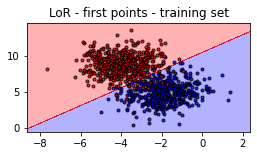

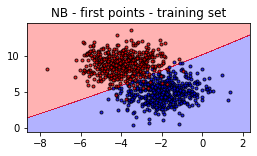

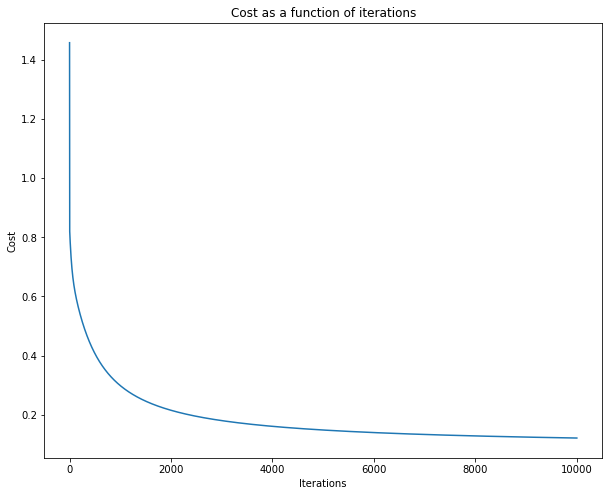

All points results: 
LoR model training accuracy is: 0.796
LoR model test accuracy is: 0.792
NB model training accuracy is: 0.8805
NB model test accuracy is: 0.86


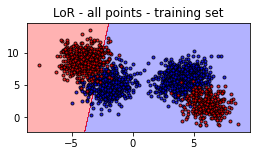

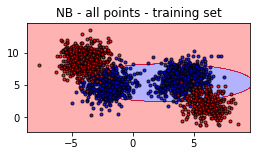

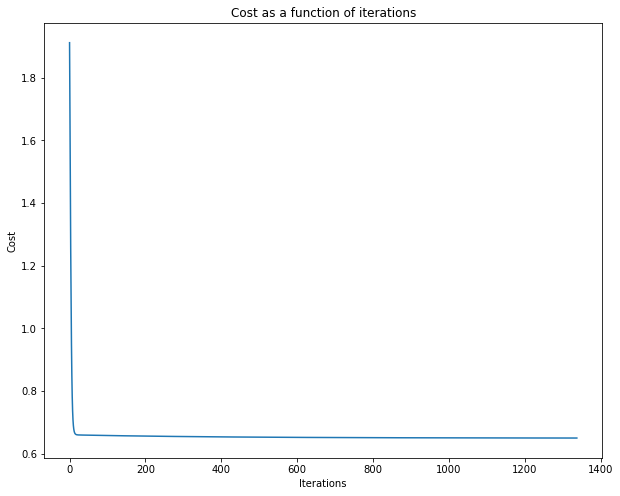

In [14]:
# First 1000 training points and 500 test points
X_training_1000 = X_training[0: 1000]
y_training_1000 = y_training[0: 1000]
X_test_500 = X_test[0: 500]
y_test_500 = y_test[0: 500]

# print(f'best_eta: {best_eta}, best_eps: {best_eps}')

print("First points results: ")
LoR_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
LoR_model.fit(X_training_1000, y_training_1000)
LoR_training_accuracy = calc_accuracy(LoR_model, X_training_1000, y_training_1000)
LoR_test_accuracy = calc_accuracy(LoR_model, X_test_500, y_test_500)
print("LoR model training accuracy is: " + str(LoR_training_accuracy))
print("LoR model test accuracy is: " + str(LoR_test_accuracy))

NB_model = NaiveBayesGaussian(k=2)
NB_model.fit(X_training_1000, y_training_1000)
NB_model_training_accuracy = calc_accuracy(NB_model, X_training_1000, y_training_1000)
NB_model_test_accuracy = calc_accuracy(NB_model, X_test_500, y_test_500)

print("NB model training accuracy is: " + str(NB_model_training_accuracy))
print("NB model test accuracy is: " + str(NB_model_test_accuracy))

plt.figure(figsize=(4,2))
plt.title("LoR - first points - training set")
plot_decision_regions(X_training_1000, y_training_1000, LoR_model)
plt.show()

plt.figure(figsize=(4,2))
plt.title("NB - first points - training set");
plot_decision_regions(X_training_1000, y_training_1000, NB_model)
plt.show()

plt.plot(np.arange(len(LoR_model.costs)), LoR_model.costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations')
plt.show()



# Second evaluation: all data
print("All points results: ")
LoR_model_2 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
LoR_model_2.fit(X_training, y_training)
LoRModel_training_accuracy = calc_accuracy(LoR_model_2, X_training, y_training)
LoRModel_test_accuracy = calc_accuracy(LoR_model_2, X_test, y_test)
print("LoR model training accuracy is: " + str(LoRModel_training_accuracy))
print("LoR model test accuracy is: " + str(LoRModel_test_accuracy))

NBModel_2 = NaiveBayesGaussian(k=4)
NBModel_2.fit(X_training, y_training)
NBModel_training_accuracy = calc_accuracy(NBModel_2, X_training, y_training)
NBModel_test_accuracy = calc_accuracy(NBModel_2, X_test, y_test)

print("NB model training accuracy is: " + str(NBModel_training_accuracy))
print("NB model test accuracy is: " + str(NBModel_test_accuracy))

plt.figure(figsize=(4,2))
plt.title("LoR - all points - training set")
plot_decision_regions(X_training, y_training, LoR_model_2)
plt.show()

plt.figure(figsize=(4,2))
plt.title("NB - all points - training set");
plot_decision_regions(X_training, y_training, NBModel_2)
plt.show()

plt.plot(np.arange(len(LoR_model_2.costs)), LoR_model_2.costs)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost as a function of iterations')
plt.show()

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


# LoR better than NB

We have added another feature 'x3' which equals the multiplication of 'x1' and 'x2'. It contradicts the basic assumption of the NB algorithm - all features are independent. The LoR is a linear calssification method that learns the probability of a sample belonging to a certain class without any dependency between features.

In [24]:
training_set_open_LoR = pd.read_csv('training_set - LoR.csv')
test_set_open_LoR = pd.read_csv('test_set - LoR.csv')
X_training_open, y_training_open = training_set_open_LoR[['x1', 'x2', 'x3']].values, training_set_open_LoR['y'].values
X_test_open, y_test_open = test_set_open_LoR[['x1', 'x2', 'x3']].values, test_set_open_LoR['y'].values

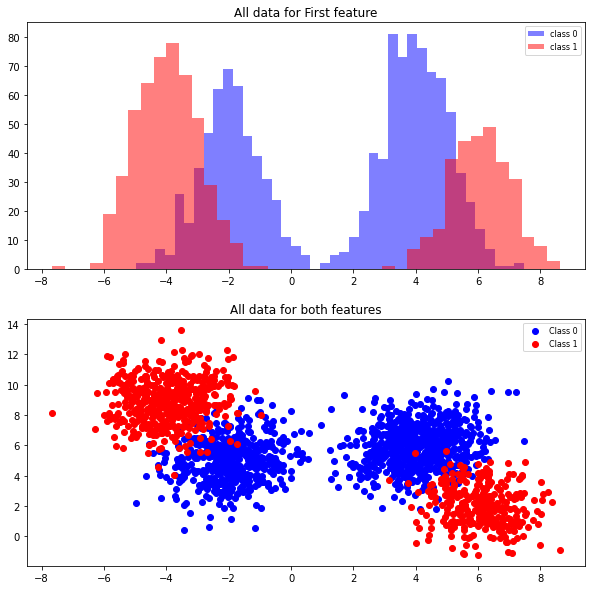

In [25]:
all_feature1_class_0 = []
all_feature1_class_1 = []
all_both_class_0 = []
all_both_class_1 = []

for i in range(X_training_open.shape[0]):
    if y_training[i] == 0:
        all_feature1_class_0.append(X_training_open[i][0])
        all_both_class_0.append(X_training_open[i][1])
    else:
        all_feature1_class_1.append(X_training_open[i][0])
        all_both_class_1.append(X_training_open[i][1])


figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].hist(all_feature1_class_0, bins=40, facecolor='b', alpha=0.5, label='class 0')
axes[0].hist(all_feature1_class_1, bins=40, facecolor='r', alpha=0.5, label='class 1')
axes[0].title.set_text("All data for First feature")
axes[0].legend(prop={'size': 8})

axes[1].scatter(all_feature1_class_0, all_both_class_0, color='b', label='Class 0')
axes[1].scatter(all_feature1_class_1, all_both_class_1, color='r', label='Class 1')
axes[1].title.set_text("All data for both features")
axes[1].legend(prop={'size': 8})

plt.show()

In [26]:
print("All points results: ")
LoR_model_2 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
LoR_model_2.fit(X_training_open, y_training_open)
LoRModel_training_accuracy = calc_accuracy(LoR_model_2, X_training_open, y_training_open)
LoRModel_test_accuracy = calc_accuracy(LoR_model_2, X_test_open, y_test_open)
print("LoR model training accuracy is: " + str(LoRModel_training_accuracy))
print("LoR model test accuracy is: " + str(LoRModel_test_accuracy))

NBModel_2 = NaiveBayesGaussian(k=4)
NBModel_2.fit(X_training_open, y_training_open)
NBModel_training_accuracy = calc_accuracy(NBModel_2, X_training_open, y_training_open)
NBModel_test_accuracy = calc_accuracy(NBModel_2, X_test_open, y_test_open)

print("NB model training accuracy is: " + str(NBModel_training_accuracy))
print("NB model test accuracy is: " + str(NBModel_test_accuracy))

All points results: 
LoR model training accuracy is: 0.941
LoR model test accuracy is: 0.935
NB model training accuracy is: 0.824
NB model test accuracy is: 0.817


# NB better than LoR

The LoR is a linear calssification method that learns the probability of a sample belonging to a certain class. If we place enough samples from one class around the other class (in a graphic way), we are able to fool the algorithm in such way that we make the model believe outliar instances actually belong the other class. It makes it much harder for the algorithm to learn the data. The NB takes into consideration the features of each sample and calculates the probability it belongs to a certain class. That's why it is less sensitive to outliars.

In [18]:
training_set_open_quest = pd.read_csv('training_set - NB.csv')
test_set_open_quest = pd.read_csv('test_set - NB.csv')
X_training_open, y_training_open = training_set_open_quest[['x1', 'x2']].values, training_set_open_quest['y'].values
X_test_open, y_test_open = test_set_open_quest[['x1', 'x2']].values, test_set_open_quest['y'].values

FileNotFoundError: [Errno 2] No such file or directory: 'training_set - NB.csv'

In [ ]:
all_feature1_class_0 = []
all_feature1_class_1 = []
all_both_class_0 = []
all_both_class_1 = []

for i in range(X_training_open.shape[0]):
    if y_training_open[i] == 0:
        all_feature1_class_0.append(X_training_open[i][0])
        all_both_class_0.append(X_training_open[i][1])
    else:
        all_feature1_class_1.append(X_training_open[i][0])
        all_both_class_1.append(X_training_open[i][1])


figure, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].hist(all_feature1_class_0, bins=40, facecolor='b', alpha=0.5, label='class 0')
axes[0].hist(all_feature1_class_1, bins=40, facecolor='r', alpha=0.5, label='class 1')
axes[0].title.set_text("All data for First feature")
axes[0].legend(prop={'size': 8})

axes[1].scatter(all_feature1_class_0, all_both_class_0, color='b', label='Class 0')
axes[1].scatter(all_feature1_class_1, all_both_class_1, color='r', label='Class 1')
axes[1].title.set_text("All data for both features")
axes[1].legend(prop={'size': 8})

plt.show()

In [ ]:
print("All points results: ")
LoR_model_2 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
LoR_model_2.fit(X_training_open, y_training_open)
LoRModel_training_accuracy = calc_accuracy(LoR_model_2, X_training_open, y_training_open)
LoRModel_test_accuracy = calc_accuracy(LoR_model_2, X_test_open, y_test_open)
print("LoR model training accuracy is: " + str(LoRModel_training_accuracy))
print("LoR model test accuracy is: " + str(LoRModel_test_accuracy))

NBModel_2 = NaiveBayesGaussian(k=4)
NBModel_2.fit(X_training_open, y_training_open)
NBModel_training_accuracy = calc_accuracy(NBModel_2, X_training_open, y_training_open)
NBModel_test_accuracy = calc_accuracy(NBModel_2, X_test_open, y_test_open)

print("NB model training accuracy is: " + str(NBModel_training_accuracy))
print("NB model test accuracy is: " + str(NBModel_test_accuracy))